<a href="https://colab.research.google.com/github/nin-ed/Midas_CNN_Task/blob/main/Midas_Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Downloading Data

In [ ]:
!wget https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip

In [ ]:
!wget https://www.dropbox.com/s/otc12z2w7f7xm8z/mnistTask3.zip?dl=0

In [ ]:
!unzip /content/trainPart1.zip -d /content/drive/MyDrive

In [ ]:
!unzip /content/mnistTask3.zip\?dl\=0 -d /content/drive/MyDrive

### Renaming Labels to their ascii characters

Changed because of odd naming of file names. Although, Pytorch does its labelling on its own when we pass the data into Dataloader.

In [ ]:
path = "/content/drive/MyDrive"

In [ ]:
import os

for i in range(1, 10):
    os.rename(f"{path}/train/Sample00{i}", f"{path}/train/{ord(f'{i-1}')}")
os.rename(f"{path}/train/Sample010", f"{path}/train/{ord('9')}")

c = ord('A')
for i in range(11, 37):
    os.rename(f"{path}/train/Sample0{i}", f"{path}/train/{c}")
    c += 1

c = ord('a')
for i in range(37, 63):
    os.rename(f"{path}/train/Sample0{i}", f"{path}/train/{c}")
    c += 1

# Part 1

### Importing Libraries

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from torchvision import transforms, datasets
import torch.nn.functional as F
from torchsummary import summary
import matplotlib.pyplot as plt

### Transformations

1. Converting images to grayscale - There isn't enough to look into the images except characters/numbers written with ink over a white base. So grayscaling will help reducing the channels and doesn't affect training much.

2. Randomly Rotating images by 45 degrees.

3. Cropping and Resizing images to dimensions - [1 x 28 x 28] (channel x width x height)

4. Randomly Flip images horizontally.

5. Converting data to tensors

6. Normalizing the images.

In [ ]:
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.RandomRotation(45),
                                transforms.RandomResizedCrop(28),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

train_data = datasets.ImageFolder(f"{path}/train", transform=transform)
trainloader = DataLoader(train_data, batch_size=64, shuffle=True)

### Model

Model consists of simple CNN model followed by fully convolutional layers.

1. CNN Layers  : 2

    a. conv1: in_channels = 1, out_channels = 16
    
    b. conv2: in_channels = 16, out_channels = 32

2. FC Layers   : 2

    a. fc1: [32*4*4, 128]

    b. fc2: [128, no_of_labels=62]

3. Dropout     : Probability = 0.2

4. Kernel Size : (5 x 5)

Kernel size is 5 because I want to retrieve local features with area covered that is not to big or small.

In [ ]:
class Model(nn.Module):
    def __init__(self, in_c, out_size):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(in_c, 16, kernel_size=(5, 5))
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(5, 5))
        self.drop = nn.Dropout(p=0.2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*4*4, 128)
        self.fc2 = nn.Linear(128, out_size)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32*4*4)
        x = self.drop(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

### Method for training

In [ ]:
def training(model, criterion, optimizer, trainloader, epochs):
    loss_list = []
    model.train()
    for e in range(epochs):
        tot_loss = 0.
        for img, lab in trainloader:
            img, lab = img.cuda(), lab.cuda()
            optimizer.zero_grad()
            pred = model.forward(img)
            loss = criterion(pred, lab)
            loss.backward()
            optimizer.step()
            tot_loss += loss.cpu().item()
        loss_list.append(tot_loss / len(trainloader))
        print(f"Epoch: {e+1}       Loss: {tot_loss / len(trainloader)}")
    return loss_list

### Model class Object Call

First argument is number of input channel.

Second argument is number of labels.

In [ ]:
model = Model(1, 62)
model = model.cuda()

### Summary 

Describes the model stack

In [ ]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 24, 24]             416
         MaxPool2d-2           [-1, 16, 12, 12]               0
            Conv2d-3             [-1, 32, 8, 8]          12,832
         MaxPool2d-4             [-1, 32, 4, 4]               0
            Linear-5                  [-1, 128]          65,664
           Dropout-6                  [-1, 128]               0
            Linear-7                   [-1, 62]           7,998
Total params: 86,910
Trainable params: 86,910
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.33
Estimated Total Size (MB): 0.44
----------------------------------------------------------------


### Loss function and Optimizer

Loss function is defined to be Negative Log Likelihood Loss.

Optimizer opted is Adam with learning rate 0.001

In [ ]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training method called for training

Epochs are assigned to 100.

In [ ]:
a_list = training(model, criterion, optimizer, trainloader, 100)

Epoch: 1       Loss: 4.132956504821777
Epoch: 2       Loss: 4.1248549436911555
Epoch: 3       Loss: 4.093358602279272
Epoch: 4       Loss: 4.010928948720296
Epoch: 5       Loss: 3.954660036625006
Epoch: 6       Loss: 3.8597369621961546
Epoch: 7       Loss: 3.807542464671991
Epoch: 8       Loss: 3.7460521979209704
Epoch: 9       Loss: 3.704121192296346
Epoch: 10       Loss: 3.6548201609880495
Epoch: 11       Loss: 3.5659786737882175
Epoch: 12       Loss: 3.5225898852715125
Epoch: 13       Loss: 3.4818061131697435
Epoch: 14       Loss: 3.4546120166778564
Epoch: 15       Loss: 3.3742815531217136
Epoch: 16       Loss: 3.3704228829114866
Epoch: 17       Loss: 3.2852475948822804
Epoch: 18       Loss: 3.2727049741989527
Epoch: 19       Loss: 3.213295478087205
Epoch: 20       Loss: 3.187677420102633
Epoch: 21       Loss: 3.179448311145489
Epoch: 22       Loss: 3.11083793028807
Epoch: 23       Loss: 3.1282212550823507
Epoch: 24       Loss: 3.1323285347376113
Epoch: 25       Loss: 3.095935424168

### Epochs vs Loss Plot

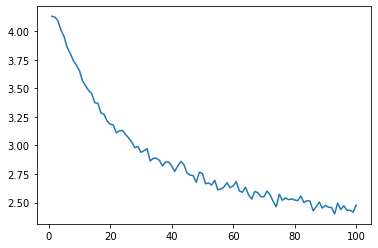

In [ ]:
epochs = [i for i in range(1, 101)]
plt.plot(epochs, a_list)

### First Checkpoint after 100 epochs.

In [ ]:
torch.save(model.cpu().state_dict(), '/content/drive/MyDrive/midas_mnist.pth')

### Training More

I wasn't satisfied by the loss. So I ran training method for 100 epochs more as it didn't converge as I expected.

In [ ]:
b_list = training(model.cuda(), criterion, optimizer, trainloader, 100)

Epoch: 1       Loss: 2.8405165794568186
Epoch: 2       Loss: 2.763847228808281
Epoch: 3       Loss: 2.7575199726300363
Epoch: 4       Loss: 2.6822248055384708
Epoch: 5       Loss: 2.684568545757196
Epoch: 6       Loss: 2.671311250099769
Epoch: 7       Loss: 2.6329941199376035
Epoch: 8       Loss: 2.617724137428479
Epoch: 9       Loss: 2.5893161663642297
Epoch: 10       Loss: 2.5378784766564
Epoch: 11       Loss: 2.5957386677081766
Epoch: 12       Loss: 2.5935913049257717
Epoch: 13       Loss: 2.5491030521881886
Epoch: 14       Loss: 2.6140789129795174
Epoch: 15       Loss: 2.519442442135933
Epoch: 16       Loss: 2.533368563040709
Epoch: 17       Loss: 2.493566788159884
Epoch: 18       Loss: 2.5318550880138693
Epoch: 19       Loss: 2.520517355356461
Epoch: 20       Loss: 2.5421722363203
Epoch: 21       Loss: 2.5120853644150953
Epoch: 22       Loss: 2.5028322476607103
Epoch: 23       Loss: 2.555984478730422
Epoch: 24       Loss: 2.493834055387057
Epoch: 25       Loss: 2.500200467231946
E

### Second Checkpoint after another 100 epochs

In [ ]:
torch.save(model.cpu().state_dict(), '/content/drive/MyDrive/midas_mnist.pth')

# Part 2

### Retrieving saved checkpoint

In [ ]:
chkpt = torch.load('/content/drive/MyDrive/midas_mnist.pth')
model.load_state_dict(chkpt)

<All keys matched successfully>

### Retrieving MNIST data and train-test split

Total Data: 60000

Training Data: 80% of data -> 48000

Testing Data: 20% of data -> 12000

In [ ]:
data = datasets.ImageFolder(f"{path}/train_sep", transform=transform)
train_data, test_data = random_split(data, [int(0.8 * len(data)), int(0.2 * len(data))])
trainloader = DataLoader(train_data, batch_size=64, shuffle=True)
testloader = DataLoader(test_data, batch_size=64, shuffle=True)

### Scrapping Last Layer and replacing layer to predict for classes 0-9.

In [ ]:
model.fc2 = nn.Linear(128, 10)
model = model.cuda()

In [ ]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 24, 24]             416
         MaxPool2d-2           [-1, 16, 12, 12]               0
            Conv2d-3             [-1, 32, 8, 8]          12,832
         MaxPool2d-4             [-1, 32, 4, 4]               0
            Linear-5                  [-1, 128]          65,664
           Dropout-6                  [-1, 128]               0
            Linear-7                   [-1, 10]           1,290
Total params: 80,202
Trainable params: 80,202
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.31
Estimated Total Size (MB): 0.42
----------------------------------------------------------------


### Optimizer Initialization

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Pretrained Network Training

In [ ]:
m_list = training(model, criterion, optimizer, trainloader, 100)

Epoch: 1       Loss: 2.5131683349609375
Epoch: 2       Loss: 2.346150779724121
Epoch: 3       Loss: 2.268466281890869
Epoch: 4       Loss: 2.1810925960540772
Epoch: 5       Loss: 2.1318502902984617
Epoch: 6       Loss: 2.062765622138977
Epoch: 7       Loss: 1.9729217290878296
Epoch: 8       Loss: 1.8988982915878296
Epoch: 9       Loss: 1.817150640487671
Epoch: 10       Loss: 1.7351985454559327
Epoch: 11       Loss: 1.6381468057632447
Epoch: 12       Loss: 1.7057775497436523
Epoch: 13       Loss: 1.5690589189529418
Epoch: 14       Loss: 1.5020303010940552
Epoch: 15       Loss: 1.5111331224441529
Epoch: 16       Loss: 1.4706021547317505
Epoch: 17       Loss: 1.3968349695205688
Epoch: 18       Loss: 1.3958688259124756
Epoch: 19       Loss: 1.3026338577270509
Epoch: 20       Loss: 1.313481593132019
Epoch: 21       Loss: 1.2555203914642334
Epoch: 22       Loss: 1.3234760522842408
Epoch: 23       Loss: 1.2395778179168702
Epoch: 24       Loss: 1.2833020448684693
Epoch: 25       Loss: 1.299830

### Randomly Initialized Network

In [ ]:
model_1 = Model(1, 62)
model_1.fc2 = nn.Linear(128, 10)
model_1 = model_1.cuda()
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.001)
ran_list = training(model_1, criterion, optimizer_1, trainloader, 100)

Epoch: 1       Loss: 2.3096978664398193
Epoch: 2       Loss: 2.295684576034546
Epoch: 3       Loss: 2.2931767463684083
Epoch: 4       Loss: 2.2808406352996826
Epoch: 5       Loss: 2.2636228084564207
Epoch: 6       Loss: 2.259546089172363
Epoch: 7       Loss: 2.240258741378784
Epoch: 8       Loss: 2.2234254837036134
Epoch: 9       Loss: 2.225475549697876
Epoch: 10       Loss: 2.2213355541229247
Epoch: 11       Loss: 2.1656837940216063
Epoch: 12       Loss: 2.23852276802063
Epoch: 13       Loss: 2.196135330200195
Epoch: 14       Loss: 2.1670187950134276
Epoch: 15       Loss: 2.1110636711120607
Epoch: 16       Loss: 2.1631218910217287
Epoch: 17       Loss: 2.152225637435913
Epoch: 18       Loss: 2.137278175354004
Epoch: 19       Loss: 2.1399670124053953
Epoch: 20       Loss: 2.132020378112793
Epoch: 21       Loss: 2.0528504610061646
Epoch: 22       Loss: 2.0737446784973144
Epoch: 23       Loss: 2.1067521810531615
Epoch: 24       Loss: 2.0990572929382325
Epoch: 25       Loss: 2.04818053245

### Comparison

In [ ]:
ep = [i for i in range(1, 101)]

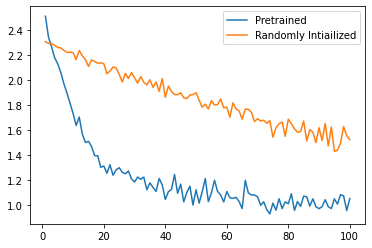

In [ ]:
plt.plot(ep, m_list)
plt.plot(ep, ran_list)
plt.legend(['Pretrained', 'Randomly Intiailized'])

Above graph shows pretrained network converges faster than randomly initialized network

### Method for Testing

In [ ]:
def testing(model, criterion, testloader):
    t_loss, acc = [], []
    model.eval()
    test_loss, acc = 0., 0.
    with torch.no_grad():
        for img, lab in testloader:
            img, lab = img.cuda(), lab.cuda()
            pred = model.forward(img)
            loss = criterion(pred, lab)
            prob = torch.exp(pred)
            top_prob, top_cl = prob.topk(1, dim=1)
            eq = top_cl == lab.view(*top_cl.shape)
            test_loss += loss.cpu().item()
            acc += torch.mean(eq.type(torch.FloatTensor))
    return test_loss/len(testloader), acc/len(testloader)

In [ ]:
p_test_loss, p_acc = testing(model, criterion, testloader)

### Test Loss of Pretrained Network

In [ ]:
p_test_loss

1.0670192241668701

### Test Accuracy of Pretrained Network

In [ ]:
p_acc

tensor(0.6641)

In [ ]:
r_test_loss, r_acc = testing(model_1, criterion, testloader)

### Test Loss of Randomly Initialized Network

In [ ]:
r_test_loss

1.414797842502594

### Test Accuracy of Randomly Initialized Network

In [ ]:
r_acc

tensor(0.5469)

In [ ]:
torch.save(model_1.cpu().state_dict(), f"{path}/midas_mnist_2.pth")

### Testing Accuracy and Loss is bad because number of epochs is less and I took 100 just for comparing convergence of models. Adding more to number of epochs will surely perform better.

# Part 3

### Retrieving Saved Checkpoint

In [ ]:
model = Model(1, 62)

In [ ]:
chkpt = torch.load('/content/drive/MyDrive/midas_mnist.pth')
model.load_state_dict(chkpt)

<All keys matched successfully>

### Retrieving MNIST data and train-test split

Total Data: 60000

Training Data: 80% of data -> 48000

Testing Data: 20% of data -> 12000

In [ ]:
data = datasets.ImageFolder(f"{path}/mnistTask", transform=transform)
train_data, test_data = random_split(data, [int(0.8 * len(data)), int(0.2 * len(data))])
trainloader = DataLoader(train_data, batch_size=64, shuffle=True)
testloader = DataLoader(test_data, batch_size=64, shuffle=True)

### Scrapping Last Layer and replacing layer to predict for classes 0-9.

In [ ]:
model.fc2 = nn.Linear(128, 10)
model = model.cuda()

In [ ]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 24, 24]             416
         MaxPool2d-2           [-1, 16, 12, 12]               0
            Conv2d-3             [-1, 32, 8, 8]          12,832
         MaxPool2d-4             [-1, 32, 4, 4]               0
            Linear-5                  [-1, 128]          65,664
           Dropout-6                  [-1, 128]               0
            Linear-7                   [-1, 10]           1,290
Total params: 80,202
Trainable params: 80,202
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.31
Estimated Total Size (MB): 0.42
----------------------------------------------------------------


### Optimizer Initialization

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Pretrained Network Training

In [ ]:
m1_list = training(model, criterion, optimizer, trainloader, 100)

In [ ]:
model_2 = Model(1, 62)
model_2.fc2 = nn.Linear(128, 10)
model_2 = model_2.cuda()
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.001)
ran1_list = training(model_2, criterion, optimizer_2, trainloader, 100)

### Comparison

In [ ]:
ep = [i for i in range(1, 51)]

In [ ]:
plt.plot(ep, m1_list)
plt.plot(ep, ran1_list)

In [ ]:
def testing(model, criterion, testloader):
    model.eval()
    test_loss, acc = 0., 0.
    with torch.no_grad():
        for img, lab in testloader:
            img, lab = img.cuda(), lab.cuda()
            pred = model.forward(img)
            loss = criterion(pred, lab)
            prob = torch.exp(pred)
            top_prob, top_cl = prob.topk(1, dim=1)
            eq = top_cl == lab.view(*top_cl.shape)
            test_loss += loss.cpu().item()
            acc += torch.mean(eq.type(torch.FloatTensor))
    return test_loss, acc

In [ ]:
p_test_loss, p_acc = testing(model, criterion, testloader)

### Test Loss of Pretrained Network

In [ ]:
p_test_loss

### Test Accuracy of Pretrained Network

In [ ]:
r_test_loss, r_acc = testing(model_2, criterion, testloader)

### Test Loss of Randomly Intialized Network

In [ ]:
r_test_loss

### Test Accuracy of Randomly Intialized Network

In [ ]:
torch.save(model_1.cpu().state_dict(), f"{path}/midas_mnist_3.pth")